In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import numpy as np
from solvers.legacy.pysat import PySAT
from solvers.legacy.base import Solver
from wagner import Wagner, InstanceSampler
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd

sns.set()

## Data generation

In [2]:
def generate_metric_data(solver: Solver, metric: str):
    cache_file = f"../.cache/test-metrics_{solver.name}_{metric}.csv.xz"
    if Path(cache_file).exists():
        df = pd.read_csv(cache_file)
        return df
    print(cache_file)

    w = Wagner(
        (25, 5),
        sampler=InstanceSampler(values=[-1, 0, 1]),
        lr=1e-3,
        frac_train=0.07,
        frac_survival=0.06,
        device="cuda",
    )
    results = w.train(
        solver,
        metric,
        generations=250,
        return_results=True,
        return_instances=True,
        instances_per_generation=1000,
    )
    results = pd.DataFrame(results)
    results.to_csv(cache_file, index=False)

    return results


def generate_data(solver: Solver, metrics: list[str]):
    results = []
    for metric in metrics:
        print(f"Generating/loading data for {solver.name}/{metric}")
        r = generate_metric_data(solver, metric)
        r["optimized_metric"] = metric
        r["iter"] = np.arange(r.shape[0]) // 1000
        results.append(r)

    return pd.concat(results, axis=0)


In [3]:
minisat = PySAT("minisat22")
results = generate_data(minisat, ["time_cpu", "restarts", "conflicts", "decisions", "propagations"])
results.head()

Generating/loading data for PySAT(minisat22)/time_cpu
Generating/loading data for PySAT(minisat22)/restarts
Generating/loading data for PySAT(minisat22)/conflicts
Generating/loading data for PySAT(minisat22)/decisions
Generating/loading data for PySAT(minisat22)/propagations


,feasible,time_cpu,restarts,conflicts,decisions,propagations,optimized_metric,iter
0,True,0.000026,1,0,5,6,time_cpu,0
1,False,0.000010,0,0,0,4,time_cpu,0
2,True,0.000014,1,1,5,9,time_cpu,0
3,True,0.000012,1,0,5,6,time_cpu,0
4,True,0.000012,1,1,4,8,time_cpu,0


## Training plots

In [4]:
def plot_training(optimized_metric: str):
    mean = (
        results[results["optimized_metric"] == optimized_metric]
        .groupby("iter")
        .mean(numeric_only=True)
    )
    for col in ["time_cpu", "restarts", "conflicts", "decisions", "propagations"]:
        y = mean[col]
        y -= y.min()
        y /= y.max()
        y.rolling(20).mean().plot()
    plt.ylabel("metric re-scaled to [0, 1]")
    plt.title(f"optimization of {optimized_metric} (rolling mean, window=20)")
    plt.legend()


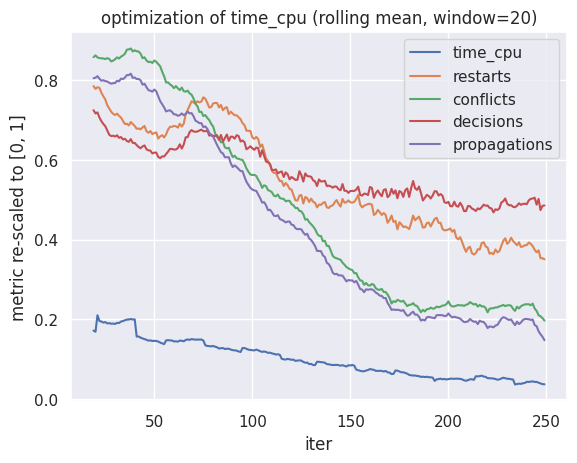

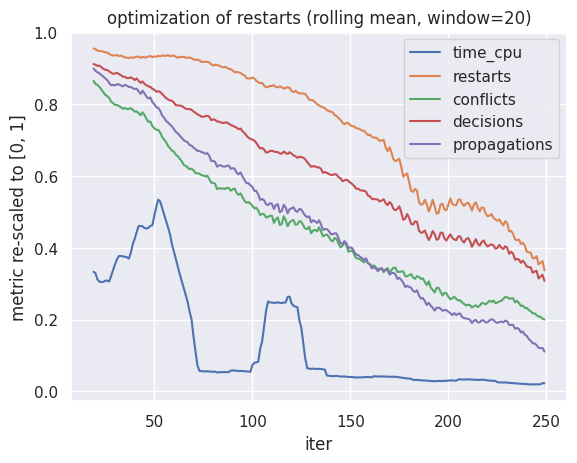

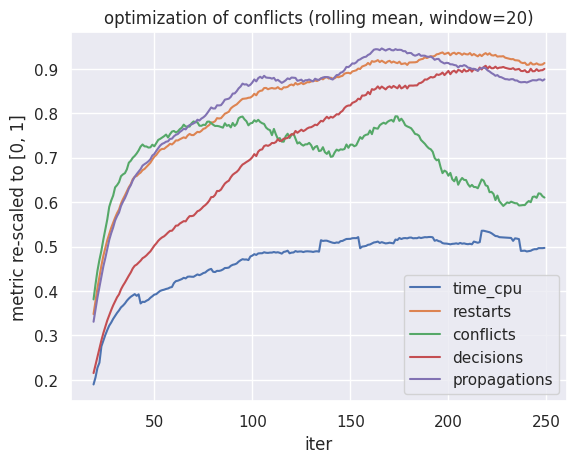

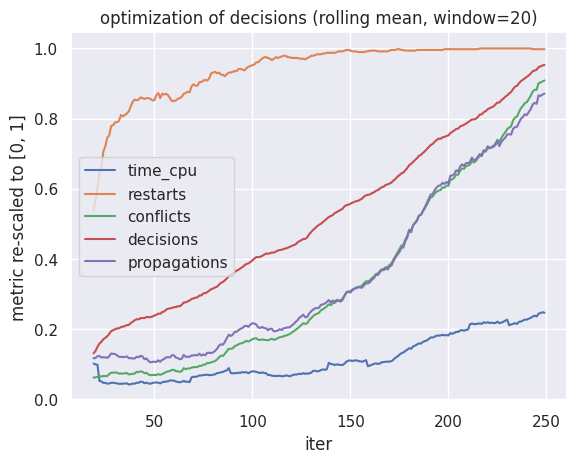

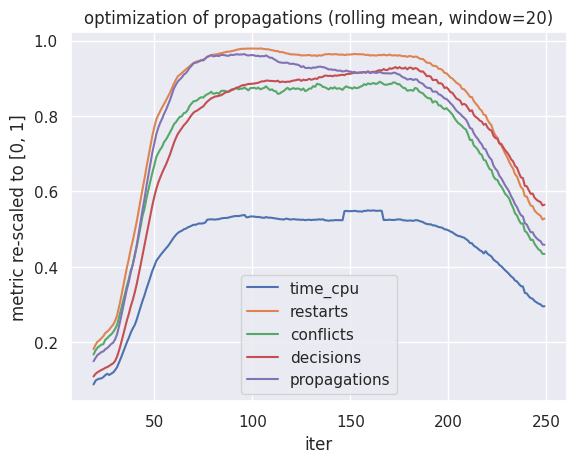

In [5]:
for col in ["time_cpu", "restarts", "conflicts", "decisions", "propagations"]:
    plot_training(col)
    plt.show()

## Distribution of time vs other metrics

In [6]:
def iqr(vals):
    return np.percentile(vals, 0.75) - np.percentile(vals, 0.25)


def plot_distributions_versus_time(x: str, y: str):
    # Plot 1 - distribution of x and y
    plt.subplot(211)
    plt.title(f"{x} x {y} (cropped in y-axis)")
    sns.violinplot(x=x, y=y, data=results)
    plt.xlabel("")

    # Update y-axis limits to hide extreme outliers
    grouped = results.groupby(x)[y]
    q1 = grouped.quantile(0.25)
    q3 = grouped.quantile(0.75)
    iqr = q3 - q1
    ymin, ymax = plt.ylim()
    ymin = max(ymin, (q1 - 3 * iqr).min())
    ymax = min(ymax, (q3 + 3 * iqr).max())
    plt.ylim(ymin, ymax)

    # Plot 2 - distribution of x
    plt.subplot(212)
    ax = sns.barplot(
        x=x,
        y="proportion",
        data=results[x]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index(),
    )
    ax.bar_label(ax.containers[0], fmt="%.2f")

    plt.tight_layout()


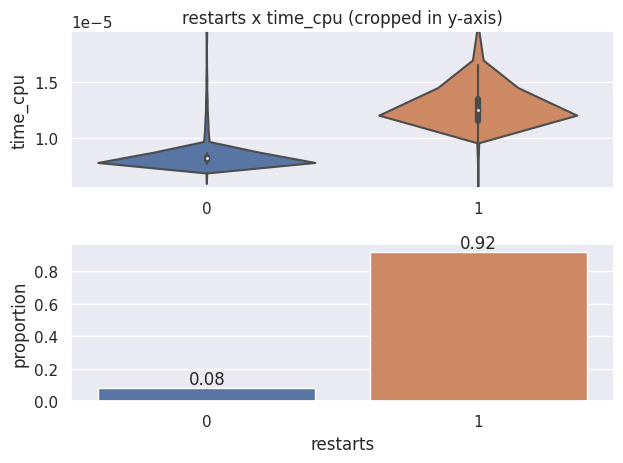

In [7]:
plot_distributions_versus_time("restarts", "time_cpu")

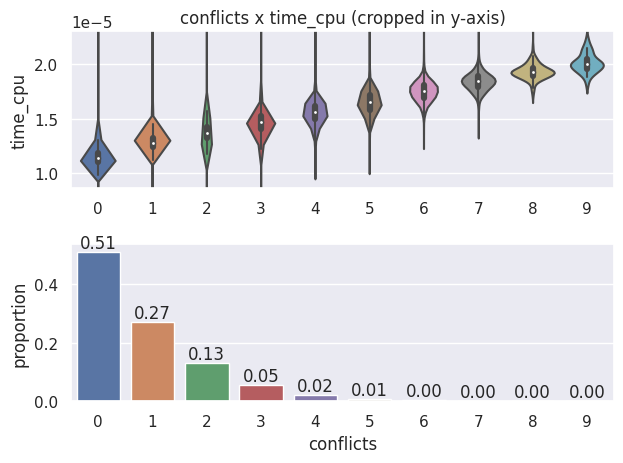

In [8]:
plot_distributions_versus_time("conflicts", "time_cpu")

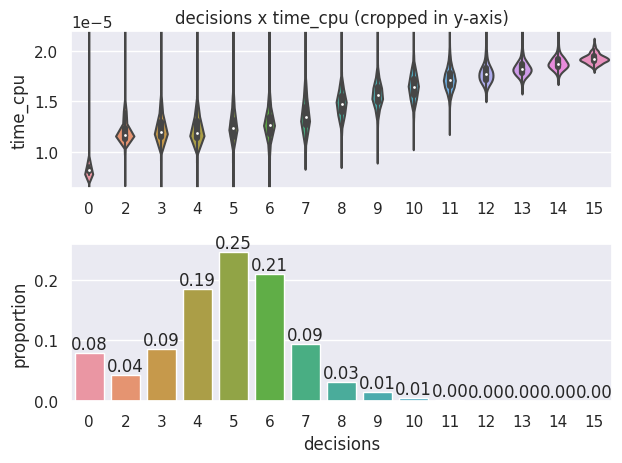

In [9]:
plot_distributions_versus_time("decisions", "time_cpu")

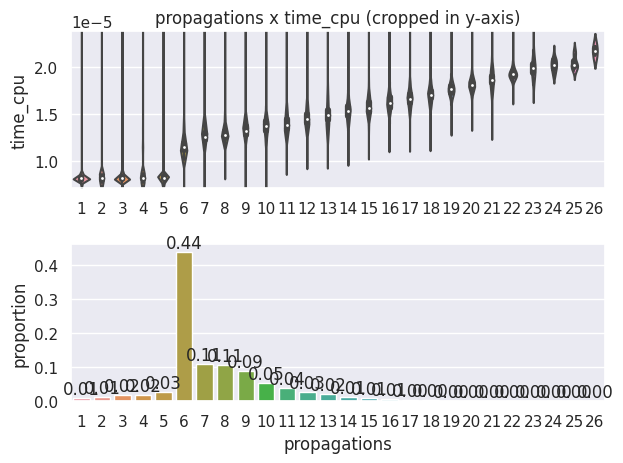

In [10]:
plot_distributions_versus_time("propagations", "time_cpu")

,time_cpu,restarts,conflicts,decisions,propagations
time_cpu,1.000000,0.461448,0.753353,0.508156,0.797348
restarts,0.461448,1.000000,0.272004,0.477134,0.490307
conflicts,0.753353,0.272004,1.000000,0.557119,0.903435
decisions,0.508156,0.477134,0.557119,1.000000,0.685665
propagations,0.797348,0.490307,0.903435,0.685665,1.000000


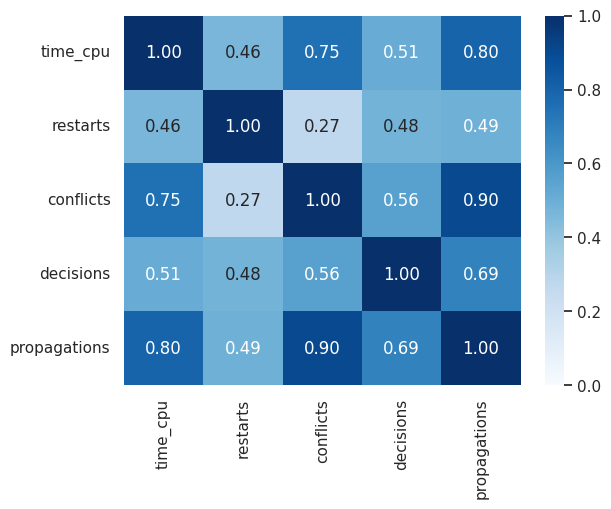

In [11]:
corr = results[["time_cpu", "restarts", "conflicts", "decisions", "propagations"]].corr("spearman")
sns.heatmap(corr, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
pd.DataFrame(corr)